In [1]:
%load_ext autoreload
%autoreload 2
import sys
import copy
import torch
import os
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import privacy_utils
sys.path.append("../")
from models.fully_connected import FullyConnected
from datasets.blobs import get_dataloaders

In [2]:
"""Set up environment, config, model and datasets"""

# Set plotting and functional parameters
sns.set_theme(context="paper", style="whitegrid", font_scale=1.6)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
SEED = 1234
HIDDEN_DIM = 128
HIDDEN_LAY = 1
BATCHSIZE = 2000
torch.manual_seed(SEED)
MARKERSIZE = 12
GRIDSIZE = 1000
GRIDLIM = 3.8
RESULTS_DIR = ".results"
NOTEBOOK_ID = "blobs_smooth_sens"
CM_BRIGHT = mpl.colors.ListedColormap(["#F45B69", "#3ABEFF"])
CM_NOMINAL = mpl.colors.ListedColormap(["#FF0000"])
CM_PRIVACY = sns.blend_palette(
    ["#ffffff", "#B5FFE1", "#93E5AB", "#65B891", "#4E878C", "#00241B"], n_colors=200, as_cmap=True
)
CM_PRIVACY = sns.blend_palette(
    ["#ffffff", "#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D", "#1A3A3A"], n_colors=200, as_cmap=True
)

# Set the nominal configuration for the certified training
NOMINAL_CONFIG = AGTConfig(
    learning_rate=2.0,
    l2_reg=0.02,
    n_epochs=2,
    device="cuda:0",
    forward_bound="interval,crown",
    backward_bound="interval",
    loss="cross_entropy",
    lr_decay=0.6,
    clip_gamma=0.08,
    lr_min=1e-3,
    early_stopping=False,
    log_level="WARNING",
)
KS_PRIVACY = list(range(0, 200, 5))

DL_TRAIN_CLOSE, DL_TEST_CLOSE = get_dataloaders(BATCHSIZE, 1, 0.75, SEED)
DL_TRAIN_FAR, DL_TEST_FAR = get_dataloaders(BATCHSIZE, 1.25, 0.35, SEED)

# Initialise the neural network model
MODEL = FullyConnected(in_dim=6, out_dim=2, hidden_dim=HIDDEN_DIM, hidden_lay=HIDDEN_LAY)

In [3]:
"""Run all sweeps."""

def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{RESULTS_DIR}/{NOTEBOOK_ID}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
        param_l = [p.to(config.device) for p in param_l]
        param_n = [p.to(config.device) for p in param_n]
        param_u = [p.to(config.device) for p in param_u]
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(SEED)
        if config.metadata == "close":
            dl_train, dl_test = DL_TRAIN_CLOSE, DL_TEST_CLOSE
        elif config.metadata == "far":
            dl_train, dl_test = DL_TRAIN_FAR, DL_TEST_FAR
        else:
            raise ValueError("metadata should be either close or far")
        param_l, param_n, param_u = agt.privacy_certified_training(
            MODEL, config, dl_train, dl_test
        )
        torch.save((param_l, param_n, param_u), fname)
    return param_l, param_n, param_u

# Run sweeps for close and far blobs datasets, for privacy
privacy_results_close = {}
privacy_results_far = {}

for k in KS_PRIVACY:
    config = copy.deepcopy(NOMINAL_CONFIG)
    config.clip_gamma = 0.08
    config.k_private = k
    config.metadata = "close"
    privacy_results_close[k] = run_with_config(config)
    config.metadata = "far"
    privacy_results_far[k] = run_with_config(config)

/tmp/ipykernel_3107889/575811220.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_l, param_n, param_u = torch.load(fname)


In [4]:
"""Compute the smooth sensitivity."""

epsilon = 1.0
delta = 10**-5
beta = epsilon / (2 * math.log(2 / delta))

# define a grid of points to evaluate the model at
x = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
y = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
X, Y = torch.meshgrid(x, y)
in_data = torch.stack(
    (
        X.flatten(),
        Y.flatten(),
        X.flatten() ** 2,
        Y.flatten() ** 2,
        X.flatten() ** 3,
        Y.flatten() ** 3,
    ),
    dim=1,
)
in_data = in_data.unsqueeze(-1).to(NOMINAL_CONFIG.device).float()

param_n = privacy_results_close[0][1]
*_, logits = agt.nominal_pass.nominal_forward_pass(in_data, param_n)
logits = logits.argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
logits_close = logits.detach().cpu().numpy()
smooth_sens_close = privacy_utils.compute_smooth_sensitivity(
    beta, in_data, torch.ones(in_data.size(0), device=NOMINAL_CONFIG.device), privacy_results_close
).cpu().numpy().reshape(GRIDSIZE, GRIDSIZE)

param_n = privacy_results_far[0][1]
*_, logits = agt.nominal_pass.nominal_forward_pass(in_data, param_n)
logits = logits.argmax(dim=1).reshape(GRIDSIZE, GRIDSIZE)
logits_far = logits.detach().cpu().numpy()
smooth_sens_far = privacy_utils.compute_smooth_sensitivity(
    beta, in_data, torch.ones(in_data.size(0), device=NOMINAL_CONFIG.device), privacy_results_far
).cpu().numpy().reshape(GRIDSIZE, GRIDSIZE)

/data/ps1623/AbstractGradientTrainingPrivate/.venv/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


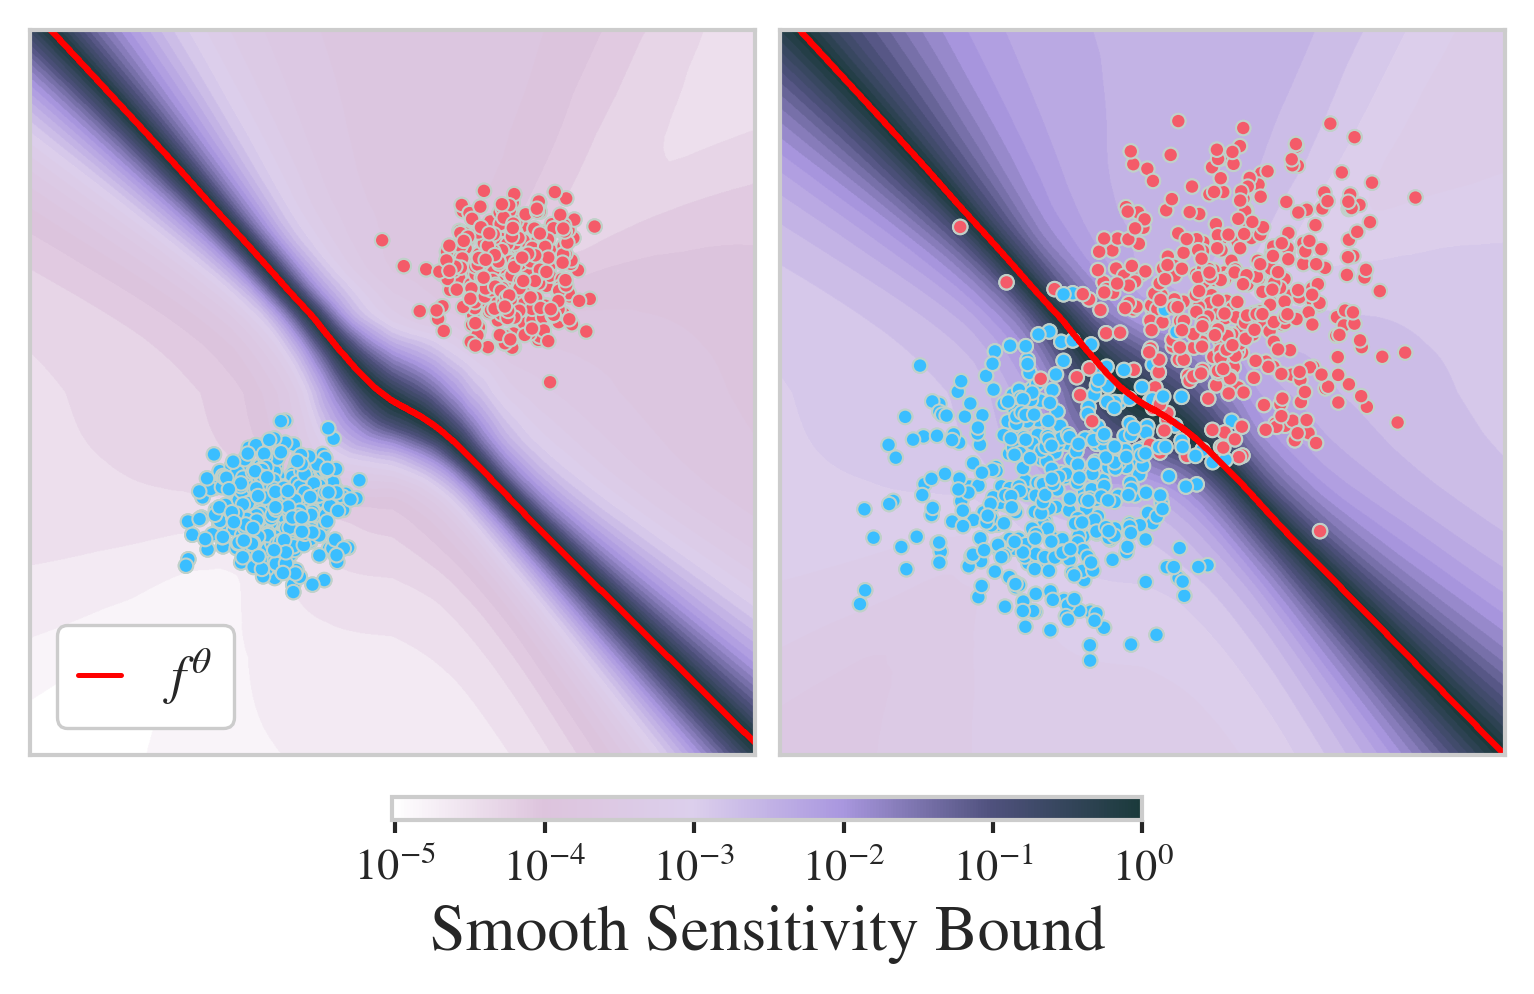

In [5]:
"""Plot the smooth sensitivity as a heatmap."""

def plot_sweep(smooth_sens, logits, dl_test, ax, cm, norm=None):
    # get the whole test dataset
    x_test, y_test = dl_test.dataset.tensors

    # define a grid of points to evaluate the model at
    x = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
    y = torch.linspace(-GRIDLIM, GRIDLIM, GRIDSIZE)
    X, Y = torch.meshgrid(x, y)

    ax.contour(X, Y, logits, cmap=CM_NOMINAL, alpha=1.0, levels=[0.5], linewidths=1.5)
    
    if norm is None:
        norm = mpl.colors.LogNorm(vmin=smooth_sens.min(), vmax=1.0)

    cont = ax.imshow(np.rot90(smooth_sens), extent=[-GRIDLIM, GRIDLIM, -GRIDLIM, GRIDLIM], norm=norm, cmap=cm)

    ax.scatter(x_test[:, 0], x_test[:, 1], s=MARKERSIZE, c=y_test, edgecolors="#c0d1c9", linewidths=0.5, cmap=CM_BRIGHT)
    ax.scatter(x_test[:, 0], x_test[:, 1], s=MARKERSIZE, c=y_test, edgecolors="#c0d1c9", linewidths=0.5, cmap=CM_BRIGHT)
    
    return norm, cont

fig, axs = plt.subplots(
    1,
    2,
    figsize=(5, 2.5),
    dpi=300,
    sharey=True,
    layout="constrained",
    gridspec_kw={"hspace": 0.01, "wspace": 0.01},
)

for ax in axs:
    ax.set_aspect("equal")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(-GRIDLIM, GRIDLIM)
    ax.set_ylim(-GRIDLIM, GRIDLIM)

norm, cont = plot_sweep(smooth_sens_far, logits_far, DL_TEST_FAR, axs[0], CM_PRIVACY)
norm, cont = plot_sweep(smooth_sens_close, logits_close, DL_TEST_CLOSE, axs[1], CM_PRIVACY, norm=norm)

cbar_ax = fig.add_axes([0.25, -0.07, 0.5, 0.03])  # [left, bottom, width, height]

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=CM_PRIVACY, norm=norm),
    cax=cbar_ax,
    orientation="horizontal",
    label="Smooth Sensitivity Bound",
    shrink=1.5,
)
cbar.ax.tick_params(length=0, width=0, which="minor")
cbar.ax.tick_params(length=3, width=1, which="major", labelsize="x-small")
cbar.ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

red_line = mpl.lines.Line2D([], [], color="red", label=r"$f^{\theta}$")
axs[0].legend(
    handles=[red_line], loc="lower left", handlelength=0.8, fontsize="small", bbox_to_anchor=(-0.0, -0.0), framealpha=1.0
)

plt.savefig(".figures/blobs_privacy_smooth_sens.pdf", bbox_inches="tight", dpi=350)